In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns

### Preparing dataset

In [2]:
file_path = 'train[1].csv'

original_df = pd.read_csv(file_path)

# Create a directed graph
original_G = nx.from_pandas_edgelist(original_df, source='source_node', target='destination_node', create_using=nx.DiGraph)

# Check the graph
print("Number of nodes:", original_G.number_of_nodes())
print("Number of edges:", original_G.number_of_edges())

Number of nodes: 1862220
Number of edges: 9437519


### Random Walk Sampliing

In [3]:
def random_walk_sampling(graph, sample_size, seed):

    random.seed(seed)

    while True:
        step_size = 0
        start_node = random.choice(list(graph.nodes()))
        selected_nodes = [start_node]
        current_node = start_node
        
        while len(selected_nodes) < sample_size:
            c = random.random()

            if c < 0.15:
                current_node = random.choice(selected_nodes)

            else:
                neighbors = list(graph.neighbors(current_node))
                if not neighbors:
                    current_node = start_node
                else:
                    current_node = random.choice(neighbors)
                    if current_node not in selected_nodes:
                        selected_nodes.append(current_node)

            step_size += 1
            if step_size > 100 * sample_size:
                # Restart if the algorithm take too many steps
                break
        if step_size > 100 * sample_size:
            continue
        else:
            sample_G = graph.subgraph(selected_nodes)
            return sample_G

In [4]:
undirected_graph = original_G.to_undirected()
print("Number of nodes:", undirected_graph.number_of_nodes())
print("Number of edges:", undirected_graph.number_of_edges())

Number of nodes: 1862220
Number of edges: 6168563


In [5]:
Largest_component = max(nx.connected_components(undirected_graph), key=len)
print(f'The largest connected component of the undirected graph has {len(Largest_component)} nodes')
print(f'The original graph has {len(undirected_graph)} nodes')
subgraph = undirected_graph.subgraph(Largest_component)

The largest connected component of the undirected graph has 1739520 nodes
The original graph has 1862220 nodes


In [6]:
print(f'The density of the graph is {nx.density(original_G)}')

The density of the graph is 2.7214233013742145e-06


In [7]:
n = len(subgraph.nodes())
m = len(subgraph.edges())
density = (2 * m) / (n * (n - 1))
print(f'The density of the graph is {density}')

The density of the graph is 3.994259492295156e-06


In [8]:
def approximate_avg_path_length(G, sample_size, seed):
    random.seed(seed)
    nodes = list(G.nodes())
    visited_pairs = set()
    total_path_length = 0
    count = 0

    while count < sample_size:
        u, v = random.sample(nodes, 2)
        if (u, v) not in visited_pairs and (v, u) not in visited_pairs:
            visited_pairs.add((u, v))
            total_path_length += nx.shortest_path_length(G, source=u, target=v)
            count += 1

    return total_path_length / count


def maslov_sneppen_randomization(G, swaps, seed):

    random.seed(seed)

    G_randomized = G.copy()

    # Perform edge swapping (Maslov-Sneppen style)
    G_randomized = nx.double_edge_swap(G_randomized, nswap=swaps, max_tries=50*swaps, seed=seed)

    # Check if the randomized graph is connected
    if not nx.is_connected(G_randomized):
        # Identify disconnected components
        components = list(nx.connected_components(G_randomized))
    
    # Reconnect the components
    for i in range(len(components) - 1):
        # Select a random node from each of the two components to connect
        node_from_comp1 = random.choice(list(components[i]))
        node_from_comp2 = random.choice(list(components[i + 1]))
        
        # Add an edge between the two nodes
        G_randomized.add_edge(node_from_comp1, node_from_comp2)

    return G_randomized


# Calculate Average shortest path length and clustering coefficient for the comparison
subgraph_avg_path_length = approximate_avg_path_length(subgraph, 10000, seed=42)
subgraph_clustering_coefficient = nx.approximation.average_clustering(subgraph, seed=42)

# Generate a maslov sneppen random graph and calculate Average shortest path length and clustering coefficient
random_graph = maslov_sneppen_randomization(subgraph, 3000000, seed=42)
random_avg_path_length = approximate_avg_path_length(random_graph, 10000, seed=42)
random_clustering_coefficient = nx.approximation.average_clustering(random_graph, seed=42)

# Show the result
print(f"Graph Clustering Coefficient: {subgraph_clustering_coefficient}")
print(f"Random Graph Clustering Coefficient: {random_clustering_coefficient}")
print(f"Graph Clustering Coefficient / Random Graph Clustering Coefficient: {subgraph_clustering_coefficient / random_clustering_coefficient}")
print(f"Graph Average Path Length: {subgraph_avg_path_length}")
print(f"Random Graph Average Path Length: {random_avg_path_length}")
print(f"Graph Average Path Length / Random Graph Average Path Length: {subgraph_avg_path_length / random_avg_path_length}")

Graph Clustering Coefficient: 0.2
Random Graph Clustering Coefficient: 0.005
Graph Clustering Coefficient / Random Graph Clustering Coefficient: 40.0
Graph Average Path Length: 7.4713
Random Graph Average Path Length: 79.8135
Graph Average Path Length / Random Graph Average Path Length: 0.09360947709347416


In [9]:
seed = 42
G = random_walk_sampling(original_G, 50000, seed)

In [10]:
G.number_of_edges()

241276

In [11]:
# Extract edges and their attributes
edges = G.edges(data=True)

# Create a DataFrame from the edges
df = pd.DataFrame(edges, columns=['source_node', 'destination_node', 'exist'])
df

,source_node,destination_node,exist
0,1703941,54822,{}
1,131080,1567940,{}
2,131080,211456,{}
3,131080,822257,{}
4,131080,46530,{}
...,...,...,...
241271,1703927,1258112,{}
241272,1703927,1707271,{}
241273,1703927,1203958,{}
241274,1703927,1142525,{}


In [12]:
sets = list(G.nodes())
edges = {}

for edge in df:
    # Marking edges present as 1
    edges[(edge[0], edge[1])] = 1

missing_edges = set([])
random.seed(seed)
# Make random edges that do not exist
while (len(missing_edges) < df.shape[0]):
    a = random.choice(sets)
    b = random.choice(sets)
    # Marking random edges as 0
    temp = edges.get((a,b),0)
    if temp == 0 and a != b:
        missing_edges.add((a,b))
    else:
        continue

In [13]:
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

print("Number of existing edges", df.shape[0])
print("Number of non-existing edges", df_neg.shape[0])

# Labeling edges' existent state
df['exist'] = 1
df_neg['exist'] = 0

# Combining
df = pd.concat([df, df_neg], axis=0).reset_index(drop=True)
df.tail()

Number of existing edges 241276
Number of non-existing edges 241276


,source_node,destination_node,exist
482547,1589702,1600866,0
482548,328473,1488274,0
482549,1836520,1504929,0
482550,1497742,1467804,0
482551,1228064,327062,0


In [14]:
# Save the sampled data to a new CSV file
df.to_csv('sampled_file.csv', index=False)

In [15]:
df = pd.read_csv('sampled_file.csv')

### Creating Features

##### Calculate the links going in and out of the user.

In [16]:
df['in_degree_source'] = df.apply(lambda row: len(set(G.predecessors(row['source_node']))), axis=1)
df['out_degree_source'] = df.apply(lambda row: len(set(G.successors(row['source_node']))), axis=1)
df['in_degree_target'] = df.apply(lambda row: len(set(G.predecessors(row['destination_node']))), axis=1)
df['out_degree_target'] = df.apply(lambda row: len(set(G.successors(row['destination_node']))), axis=1)

In [17]:
df

,source_node,destination_node,exist,in_degree_source,out_degree_source,in_degree_target,out_degree_target
0,1703941,54822,1,1,1,10,10
1,131080,1567940,1,2,5,4,3
2,131080,211456,1,2,5,2,2
3,131080,822257,1,2,5,4,5
4,131080,46530,1,2,5,3,0
...,...,...,...,...,...,...,...
482547,1589702,1600866,0,5,5,1,3
482548,328473,1488274,0,3,3,2,2
482549,1836520,1504929,0,3,3,7,4
482550,1497742,1467804,0,17,17,9,12


##### Shortest path is the least amount of links needed to go from 1 user to another.

In [18]:
def shortest_path(G,a,b):
    p=-1
    try:
        p = nx.shortest_path_length(G,source=a,target=b)
        if G.has_edge(a,b):
            G.remove_edge(a,b)
            try:
              p = nx.shortest_path_length(G,source=a,target=b)
            except:
              p = -1
            G.add_edge(a,b)
        return p
    except:
        return -1

df['path'] = df.apply(lambda row: shortest_path(G, row['source_node'], row['destination_node']), axis=1)

##### A user who is followed by other user are more likely to follow back

In [19]:
def follow_back(G,a,b):
    if G.has_edge(b,a):
        return 1
    else:
        return 0

df['follow_back'] = df.apply(lambda row: follow_back(G, row['source_node'], row['destination_node']), axis=1)

##### Preferencial attachment indicates that a user who has more links tend to connect with more users.

In [20]:
def preference(G,a,b):
    try:
        score=(len(set(G.successors(a)))*len(set(G.predecessors(b))))
        return score
    except:
        return 0

df['preference'] = df.apply(lambda row: preference(G, row['source_node'], row['destination_node']), axis=1)

##### Cosine similarity represents how similar a user is to another user based on the angle between the vectors of the two users' connection.

In [21]:
def cosine_similarity(G,a,b):
    try:
        set1 = set(G.successors(a)).union(set(G.predecessors(a)))
        set2 = set(G.successors(b)).union(set(G.predecessors(b)))
        sim = (len(set1.intersection(set2)))/(math.sqrt(len(set1)*len((set2))))
        return sim
    except:
        return 0

df['cosine_similarity'] = df.apply(lambda row: cosine_similarity(G, row['source_node'], row['destination_node']), axis=1)

##### Jaccard similarity is the proportion of shared connections to the overall connections of two different users.

In [22]:
def jaccard_similarity(G,a,b):
    try:
      set1 = set(G.successors(a)).union(set(G.predecessors(a)))
      set2 = set(G.successors(b)).union(set(G.predecessors(b)))
      sim = (len(set1.intersection(set2)))/(len(set1.union(set2)))
    except:
      return 0
    return sim

df['jaccard_similarity'] = df.apply(lambda row: jaccard_similarity(G, row['source_node'], row['destination_node']), axis=1)

##### Eigenvector centralities measure a user's importance according to the importance of its predecessors.

In [23]:
eig = nx.eigenvector_centrality(G)
df['eigenvector_source'] = df.apply(lambda row: eig[row['source_node']], axis=1)
df['eigenvector_target'] = df.apply(lambda row: eig[row['destination_node']], axis=1)

##### PageRank is an algorithm that represents a user's importance based on random walking on the graph.

In [24]:
pr = nx.pagerank(G)
df['page_rank_source'] = df.apply(lambda row: pr[row['source_node']], axis=1)
df['page_rank_target'] = df.apply(lambda row: pr[row['destination_node']], axis=1)

##### HITS (Hyperlink-Induced Topic Search) algorithm calculates two values for each user node based on their roles as hubs (pointing to many nodes) and authorities (being pointed to by many nodes).

In [25]:
hits_authorities, hits_hubs = nx.hits(G)
df['hits_auth_source'] = df.apply(lambda row: hits_authorities[row['source_node']], axis=1)
df['hits_hub_source'] = df.apply(lambda row: hits_hubs[row['source_node']], axis=1)
df['hits_auth_target'] = df.apply(lambda row: hits_authorities[row['destination_node']], axis=1)
df['hits_hub_target'] = df.apply(lambda row: hits_hubs[row['destination_node']], axis=1)

Resource allocation index calculates link value relevant to the common neighbors between two users, weigthed accordingly to differentiate celebrity links and normal links.

In [26]:
def resource_allocation(G, a, b):
    cn = set(G.successors(a)).intersection(set(G.predecessors(b)))
    # s1 = G.successors(a)
    # s2 = G.predecessors(b)
    index = sum(1 / G.degree(w) for w in cn if G.degree(w) > 0)
    return index

df['resource_allocation'] = df.apply(lambda row: resource_allocation(G, row['source_node'], row['destination_node']), axis=1)

##### Weight determines the strength of the link going in and out of a user proportioned with the degree.

In [27]:
weight = {}
for i in  G.nodes():
    s1 =set(G.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s1)))
    s2 =set(G.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s2)))
    weight[i]= [w_in, w_out]

df['weight_in_source'] = df.apply(lambda row: weight[row['source_node']][0], axis=1)
df['weight_out_source'] = df.apply(lambda row: weight[row['source_node']][1], axis=1)
df['weight_in_target'] = df.apply(lambda row: weight[row['destination_node']][0], axis=1)
df['weight_out_target'] = df.apply(lambda row: weight[row['destination_node']][1], axis=1)

In [28]:
df.head()

,source_node,destination_node,exist,in_degree_source,out_degree_source,in_degree_target,out_degree_target,path,follow_back,preference,...,page_rank_target,hits_auth_source,hits_hub_source,hits_auth_target,hits_hub_target,resource_allocation,weight_in_source,weight_out_source,weight_in_target,weight_out_target
0,1703941,54822,1,1,1,10,10,-1,1,10,...,0.000042,3.199372e-13,2.150630e-13,9.403360e-12,1.360855e-11,0.000000,0.707107,0.707107,0.301511,0.301511
1,131080,1567940,1,2,5,4,3,-1,1,20,...,0.000026,2.668138e-13,6.087910e-15,4.430207e-16,1.237327e-14,0.000000,0.577350,0.408248,0.447214,0.500000
2,131080,211456,1,2,5,2,2,-1,0,10,...,0.000009,2.668138e-13,6.087910e-15,2.660209e-13,1.067515e-14,0.111111,0.577350,0.408248,0.577350,0.577350
3,131080,822257,1,2,5,4,5,-1,0,20,...,0.000014,2.668138e-13,6.087910e-15,1.999914e-13,1.129846e-11,0.500000,0.577350,0.408248,0.447214,0.408248
4,131080,46530,1,2,5,3,0,-1,0,15,...,0.000012,2.668138e-13,6.087910e-15,-0.000000e+00,1.675840e-14,0.361111,0.577350,0.408248,0.500000,1.000000


In [29]:
# Remove node id and position the target variable, run once only
cols = df.columns.tolist()
cols = cols[3:] + cols[2:3]
df = df[cols]

In [30]:
df.shape

(482552, 23)

In [31]:
df.to_csv('file_for_prediction.csv', index=False)

In [32]:
df = pd.read_csv('file_for_prediction.csv')

In [33]:
data_types_df = pd.DataFrame(columns=['Attribute', 'Data Type'])

# Iterate through columns of the DataFrame
for column in df.columns:
    data_types_df = pd.concat([data_types_df, pd.DataFrame({'Attribute': [column], 'Data Type': [df[column].dtype]})], ignore_index=True)

# Display the DataFrame containing attribute names and data types
print(data_types_df)

              Attribute Data Type
0      in_degree_source     int64
1     out_degree_source     int64
2      in_degree_target     int64
3     out_degree_target     int64
4                  path     int64
5           follow_back     int64
6            preference     int64
7     cosine_similarity   float64
8    jaccard_similarity   float64
9    eigenvector_source   float64
10   eigenvector_target   float64
11     page_rank_source   float64
12     page_rank_target   float64
13     hits_auth_source   float64
14      hits_hub_source   float64
15     hits_auth_target   float64
16      hits_hub_target   float64
17  resource_allocation   float64
18     weight_in_source   float64
19    weight_out_source   float64
20     weight_in_target   float64
21    weight_out_target   float64
22                exist     int64


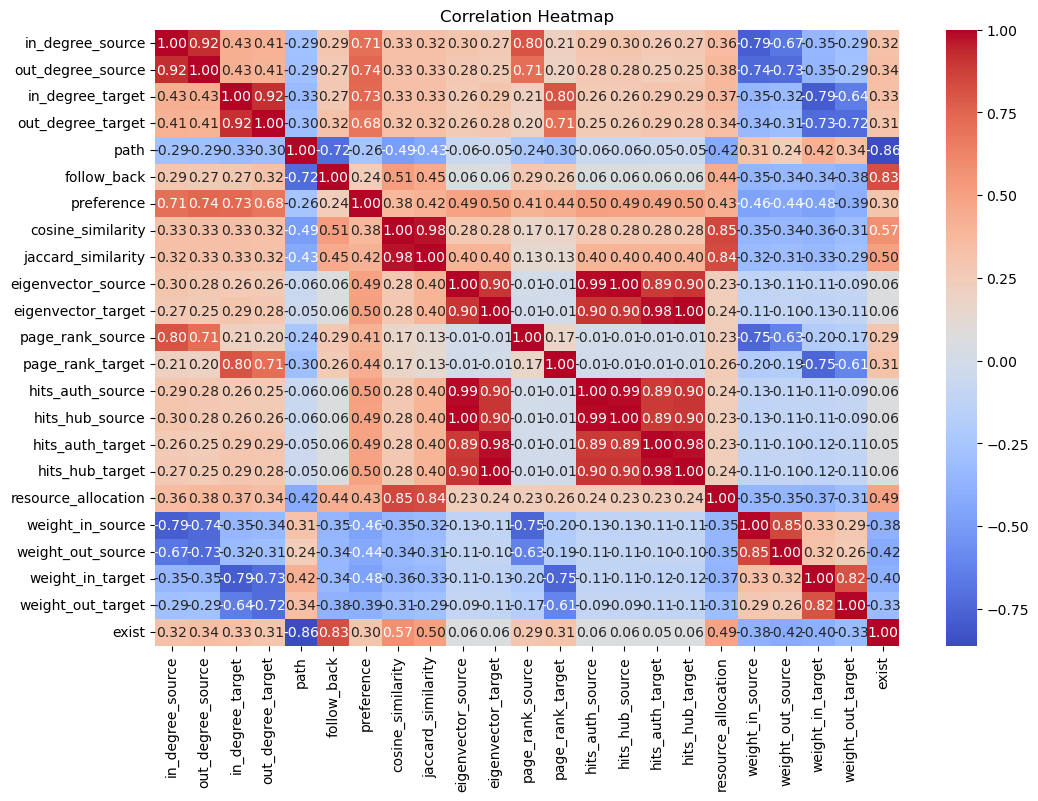

In [34]:
# Plotting the correlation heatmap for the filtered DataFrame
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [35]:
correlation_matrix = df.corr()

# Identify strong positive correlations
strong_positive_corr = correlation_matrix[correlation_matrix >= 0.5]

# Create a list to store pairs of strongly correlated attributes
strong_corr_pairs = []

# Iterate through the correlation matrix to find pairs
for column in strong_positive_corr.columns:
    for index in strong_positive_corr.index:
        if column != index and strong_positive_corr.loc[index, column] >= 0.5:
            strong_corr_pairs.append((index, column, strong_positive_corr.loc[index, column]))

# Remove duplicates (e.g., (A, B) and (B, A))
strong_corr_pairs = list(set(tuple(sorted(pair[:2])) + (pair[2],) for pair in strong_corr_pairs))

# Create a DataFrame for better visualization
strong_corr_df = pd.DataFrame(strong_corr_pairs, columns=['Attribute 1', 'Attribute 2', 'Correlation'])
strong_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)  # Sort by correlation value



print(strong_corr_df)

           Attribute 1          Attribute 2  Correlation
34  eigenvector_target      hits_hub_target     0.999905
26  eigenvector_source      hits_hub_source     0.999903
32    hits_auth_source      hits_hub_source     0.987558
22  eigenvector_source     hits_auth_source     0.987508
1   eigenvector_target     hits_auth_target     0.981961
4     hits_auth_target      hits_hub_target     0.981750
13   cosine_similarity   jaccard_similarity     0.977308
24    in_degree_source    out_degree_source     0.923917
5     in_degree_target    out_degree_target     0.918387
7      hits_hub_source      hits_hub_target     0.904162
6   eigenvector_source      hits_hub_target     0.903800
9   eigenvector_target      hits_hub_source     0.903736
21  eigenvector_source   eigenvector_target     0.903369
14    hits_auth_source      hits_hub_target     0.901061
2   eigenvector_target     hits_auth_source     0.900462
11    hits_auth_target      hits_hub_source     0.890693
0   eigenvector_source     hits

In [36]:
# Output the DataFrame to a CSV file
strong_corr_df.to_csv('strong_correlations.csv', index=False)

In [37]:
correlation_matrix = df.corr()

# Identify strong negative correlations
strong_negative_corr = correlation_matrix[correlation_matrix <= -0.5]

# Create a list to store pairs of strongly negatively correlated attributes
strong_neg_corr_pairs = []

# Iterate through the correlation matrix to find pairs
for column in strong_negative_corr.columns:
    for index in strong_negative_corr.index:
        if column != index and strong_negative_corr.loc[index, column] <= -0.5:
            strong_neg_corr_pairs.append((index, column, strong_negative_corr.loc[index, column]))

# Remove duplicates (e.g., (A, B) and (B, A))
strong_neg_corr_pairs = list(set(tuple(sorted(pair[:2])) + (pair[2],) for pair in strong_neg_corr_pairs))

# Create a DataFrame for better visualization
strong_neg_corr_df = pd.DataFrame(strong_neg_corr_pairs, columns=['Attribute 1', 'Attribute 2', 'Correlation'])
strong_neg_corr_df.sort_values(by='Correlation', inplace=True)  # Sort by correlation value

# Output the table
print(strong_neg_corr_df)

          Attribute 1        Attribute 2  Correlation
4               exist               path    -0.861070
10   in_degree_target   weight_in_target    -0.788501
9    in_degree_source   weight_in_source    -0.787947
13   page_rank_source   weight_in_source    -0.751033
2    page_rank_target   weight_in_target    -0.749523
8   out_degree_source   weight_in_source    -0.735590
5   out_degree_target   weight_in_target    -0.728957
3   out_degree_source  weight_out_source    -0.725087
7   out_degree_target  weight_out_target    -0.716901
12        follow_back               path    -0.716428
0    in_degree_source  weight_out_source    -0.672963
11   in_degree_target  weight_out_target    -0.644823
1    page_rank_source  weight_out_source    -0.627197
6    page_rank_target  weight_out_target    -0.611086


In [38]:
# Output the DataFrame to a CSV file
strong_neg_corr_df.to_csv('strong_correlations.csv', index=False)

Complementary Cumulative Distribution function plots for degree distributions

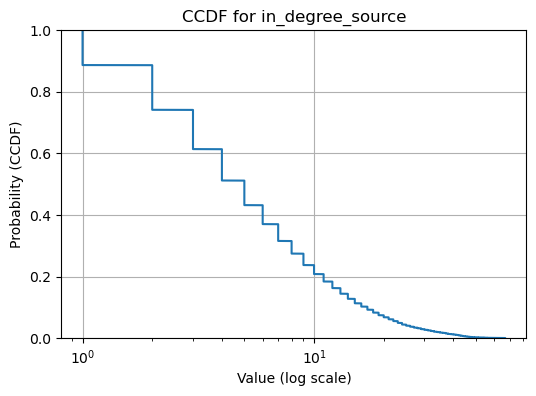

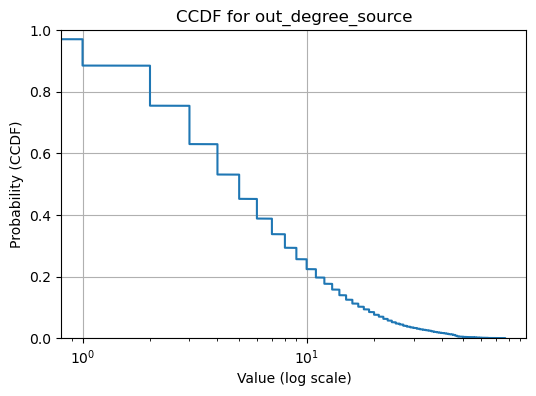

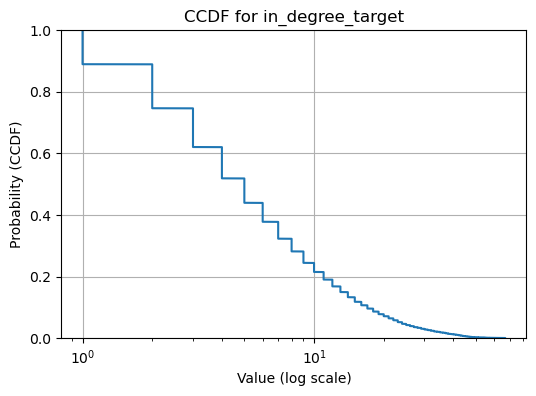

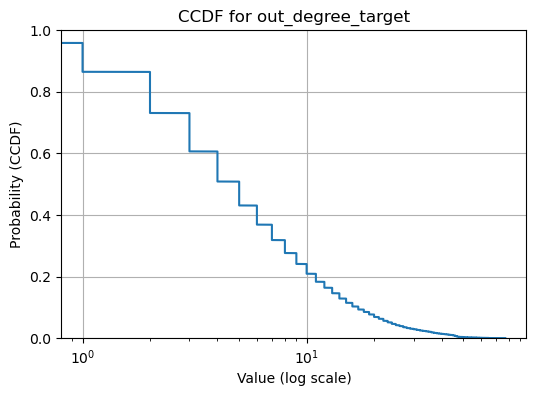

In [39]:
attributes = ['in_degree_source', 'out_degree_source', 'in_degree_target', 'out_degree_target']

# Loop through each attribute and create a separate CCDF plot
for attribute in attributes:
    plt.figure(figsize=(6, 4))

    # Calculate the CCDF
    data = df[attribute]
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ccdf = 1 - cdf  # Complementary CDF

    # Plot CCDF for the current attribute
    plt.plot(sorted_data, ccdf)

    plt.xlabel('Value (log scale)')
    plt.ylabel('Probability (CCDF)')
    plt.title(f'CCDF for {attribute}')
    plt.grid(True)
    plt.xscale('log')  # Set the x-axis to logarithmic scale
    plt.ylim(0, 1)  # Ensure the y-axis is between 0 and 1
    plt.show()

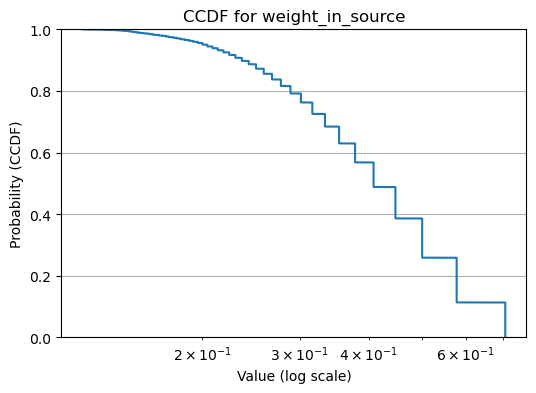

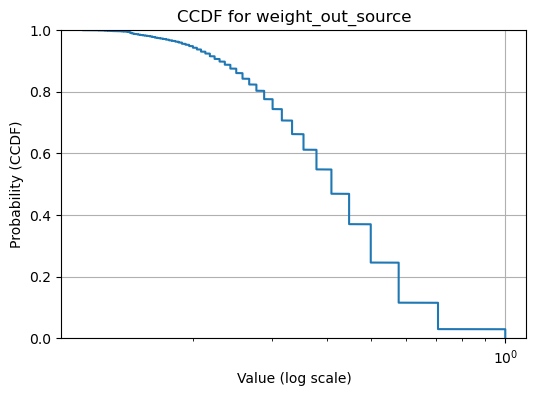

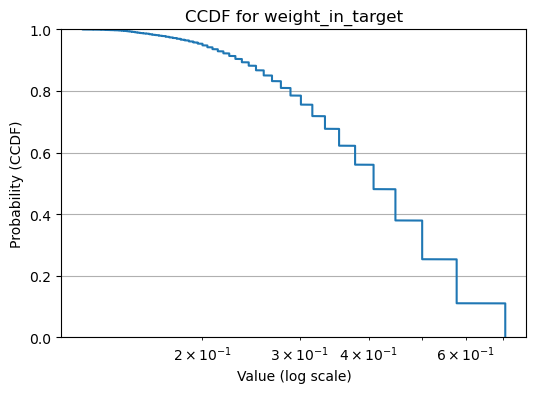

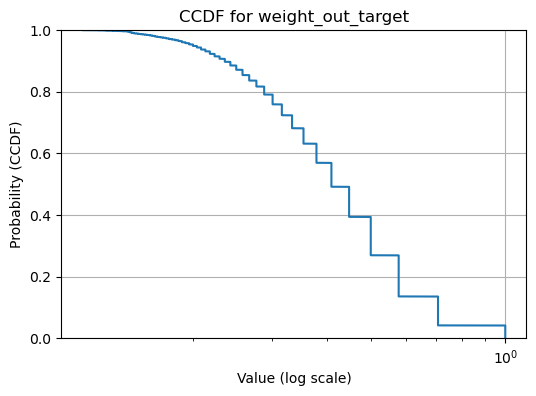

In [40]:
attributes = ['weight_in_source', 'weight_out_source', 'weight_in_target', 'weight_out_target']

# Loop through each attribute and create a separate CCDF plot
for attribute in attributes:
    plt.figure(figsize=(6, 4))

    # Calculate the CCDF
    data = df[attribute]
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ccdf = 1 - cdf  # Complementary CDF

    # Plot CCDF for the current attribute
    plt.plot(sorted_data, ccdf)

    plt.xlabel('Value (log scale)')
    plt.ylabel('Probability (CCDF)')
    plt.title(f'CCDF for {attribute}')
    plt.grid(True)
    plt.xscale('log')  # Set the x-axis to logarithmic scale
    plt.ylim(0, 1)  # Ensure the y-axis is between 0 and 1
    plt.show()

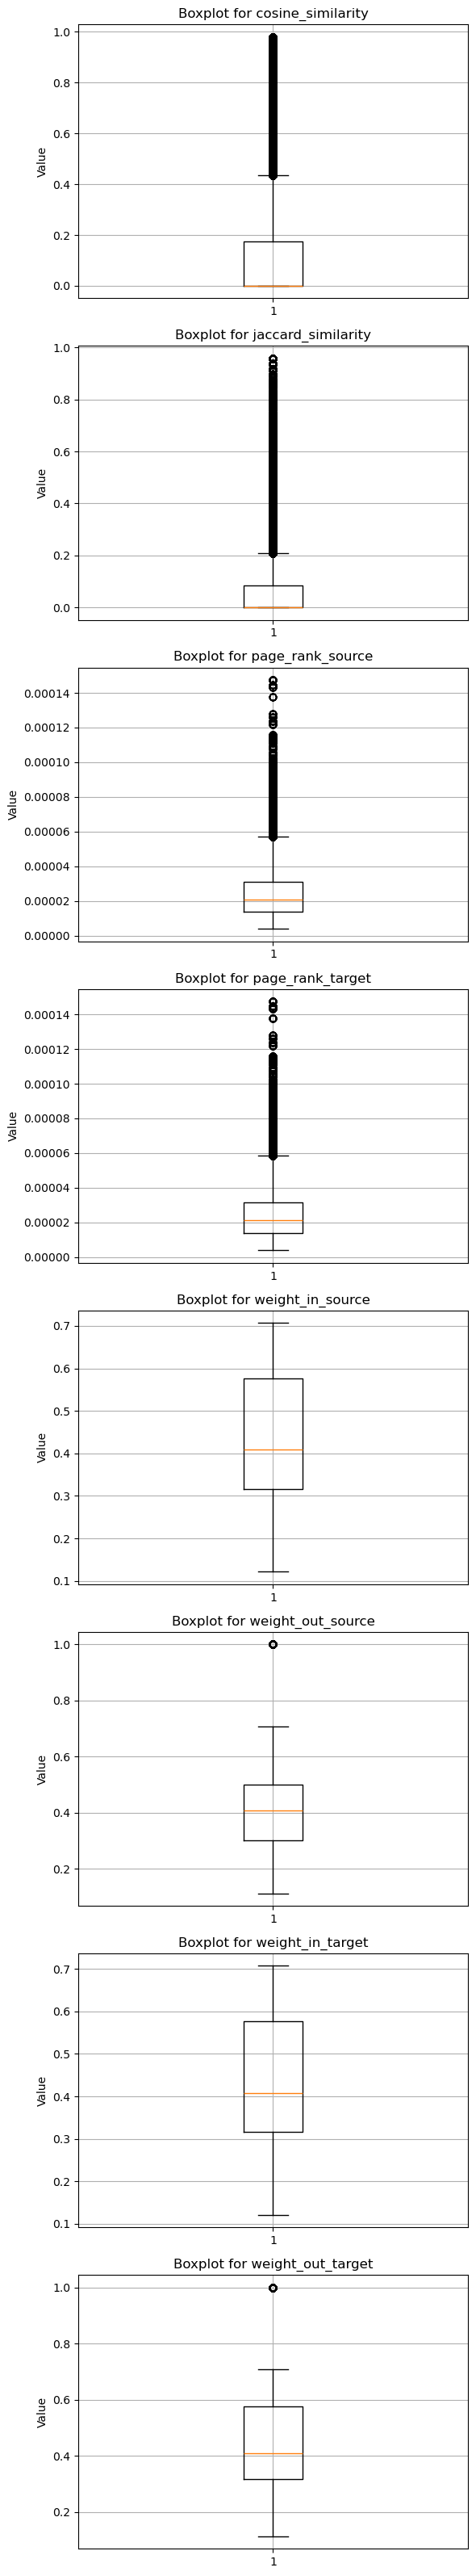

In [41]:
attributes = ['cosine_similarity', 'jaccard_similarity',
              'page_rank_source', 'page_rank_target',
              'weight_in_source', 'weight_out_source', 'weight_in_target', 'weight_out_target']

# Create a figure with subplots for each box plot
fig, axs = plt.subplots(len(attributes), 1, figsize=(6, 4 * len(attributes)))

# Loop through each attribute and create a separate box plot
for i, attribute in enumerate(attributes):
    plt.subplot(len(attributes), 1, i+1)
    plt.boxplot(df[attribute].dropna())
    plt.title(f'Boxplot for {attribute}')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
df.head()

,in_degree_source,out_degree_source,in_degree_target,out_degree_target,path,follow_back,preference,cosine_similarity,jaccard_similarity,eigenvector_source,...,hits_auth_source,hits_hub_source,hits_auth_target,hits_hub_target,resource_allocation,weight_in_source,weight_out_source,weight_in_target,weight_out_target,exist
0,1,1,10,10,-1,1,10,0.000000,0.000000,1.975174e-08,...,3.199372e-13,2.150630e-13,9.403360e-12,1.360855e-11,0.000000,0.707107,0.707107,0.301511,0.301511,1
1,2,5,4,3,-1,1,20,0.000000,0.000000,6.541054e-12,...,2.668138e-13,6.087910e-15,4.430207e-16,1.237327e-14,0.000000,0.577350,0.408248,0.447214,0.500000,1
2,2,5,2,2,-1,0,10,0.516398,0.333333,6.541054e-12,...,2.668138e-13,6.087910e-15,2.660209e-13,1.067515e-14,0.111111,0.577350,0.408248,0.577350,0.577350,1
3,2,5,4,5,-1,0,20,0.547723,0.375000,6.541054e-12,...,2.668138e-13,6.087910e-15,1.999914e-13,1.129846e-11,0.500000,0.577350,0.408248,0.447214,0.408248,1
4,2,5,3,0,-1,0,15,0.516398,0.333333,6.541054e-12,...,2.668138e-13,6.087910e-15,-0.000000e+00,1.675840e-14,0.361111,0.577350,0.408248,0.500000,1.000000,1


In [43]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'exist']
y = df['exist']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train

,in_degree_source,out_degree_source,in_degree_target,out_degree_target,path,follow_back,preference,cosine_similarity,jaccard_similarity,eigenvector_source,...,page_rank_target,hits_auth_source,hits_hub_source,hits_auth_target,hits_hub_target,resource_allocation,weight_in_source,weight_out_source,weight_in_target,weight_out_target
105864,3,2,5,5,-1,1,10,0.000000,0.0,2.449776e-07,...,0.000030,5.055962e-12,4.149320e-11,1.673283e-10,2.066977e-11,0.000000,0.500000,0.577350,0.408248,0.408248
463511,2,3,8,9,9,0,24,0.000000,0.0,2.112932e-09,...,0.000041,1.449127e-13,5.655875e-15,1.620533e-10,1.113617e-11,0.000000,0.577350,0.500000,0.333333,0.316228
289573,11,10,4,1,9,0,40,0.000000,0.0,8.786527e-06,...,0.000017,7.943174e-10,1.056918e-10,1.799025e-13,2.453966e-16,0.000000,0.288675,0.301511,0.447214,0.707107
129098,2,2,6,8,-1,1,12,0.000000,0.0,5.382740e-09,...,0.000023,4.117946e-13,3.464418e-13,7.374831e-12,8.587402e-12,0.000000,0.577350,0.577350,0.377964,0.333333
458362,4,9,2,2,9,0,18,0.000000,0.0,1.922374e-09,...,0.000019,3.030449e-12,2.634341e-13,6.058152e-21,1.612135e-16,0.000000,0.447214,0.316228,0.577350,0.577350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439107,3,3,2,2,10,0,6,0.000000,0.0,3.510552e-11,...,0.000017,1.956882e-15,7.335201e-14,1.132931e-13,7.413619e-14,0.000000,0.500000,0.500000,0.577350,0.577350
117952,3,3,2,3,-1,1,6,0.333333,0.2,6.608906e-10,...,0.000011,1.580657e-10,1.092101e-11,1.587940e-10,1.089025e-11,0.071429,0.500000,0.500000,0.577350,0.500000
435829,13,14,4,4,8,0,56,0.000000,0.0,1.030201e-07,...,0.000012,6.207621e-13,5.037647e-12,2.331177e-13,3.584767e-13,0.000000,0.267261,0.258199,0.447214,0.447214
305711,2,2,1,1,-1,0,2,0.000000,0.0,3.645318e-16,...,0.000005,-5.826056e-21,2.831669e-19,6.678072e-21,5.520429e-12,0.000000,0.577350,0.577350,0.707107,0.707107


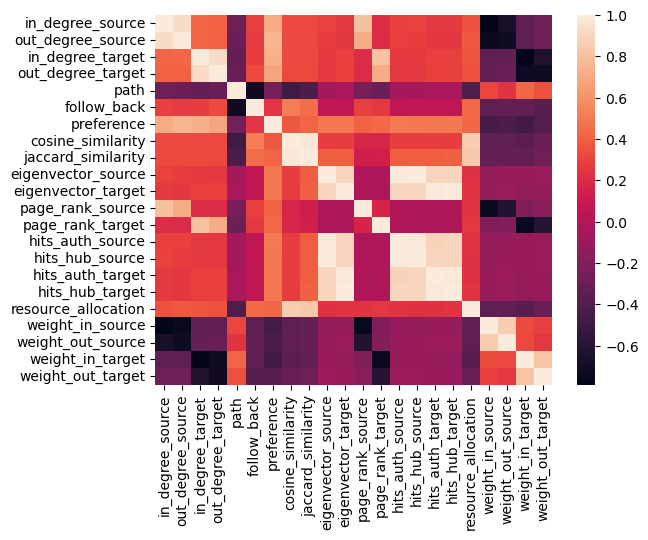

In [44]:
# Mean
X_mean = X_train.mean()

# Standard deviation
X_std = X_train.std()

# Standardization
Z = (X_train - X_mean) / X_std

# covariance
c = Z.cov()

# Plot the covariance matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(c)
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Create an instance of StandardScaler
scaler = StandardScaler()
pca = PCA(n_components=15)

# Fit standardization and PCA on the training data and transform it
X_trained_standardized = scaler.fit_transform(X_train)
X_trained_pca = pca.fit_transform(X_trained_standardized)


# Transform the test data using the same standardization and PCA
X_test_standardized = scaler.transform(X_test)
X_test_pca = pca.fit_transform(X_test_standardized)

print("Train set Original shape:", X_train.shape)
print("Train set After Standardization:", X_trained_standardized.shape)
print("Train set After PCA:", X_trained_pca.shape)

print("Test set Original shape:", X_test.shape)
print("Test set After Standardization:", X_test_standardized.shape)
print("Test set After PCA:", X_test_pca.shape)

Train set Original shape: (386041, 22)
Train set After Standardization: (386041, 22)
Train set After PCA: (386041, 15)
Test set Original shape: (96511, 22)
Test set After Standardization: (96511, 22)
Test set After PCA: (96511, 15)


### Support Vector Machine

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear']
}


# Set up StratifiedKFold with random_state for reproducibility
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Initialize SVM model
svm_model = SVC(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
svc_grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)

# Fit the model to the training data
svc_grid_search.fit(X_trained_pca, y_train)

# Get the best hyperparameters
print("Best Hyperparameters:", svc_grid_search.best_params_)

# Get the best cross-validation score
print("Best Cross-Validation Score:", svc_grid_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...............................C=0.1, kernel=linear; total time=  50.9s
[CV] END ...............................C=0.1, kernel=linear; total time=  50.0s
[CV] END ...............................C=0.1, kernel=linear; total time=  45.3s
[CV] END ...............................C=0.1, kernel=linear; total time=  44.2s
[CV] END ...............................C=0.1, kernel=linear; total time=  44.6s
[CV] END .................................C=1, kernel=linear; total time=  54.6s
[CV] END .................................C=1, kernel=linear; total time=  57.4s
[CV] END .................................C=1, kernel=linear; total time=  54.0s
[CV] END .................................C=1, kernel=linear; total time=  49.1s
[CV] END .................................C=1, kernel=linear; total time=  58.1s
[CV] END ................................C=10, kernel=linear; total time= 1.9min
[CV] END ................................C=10, ke

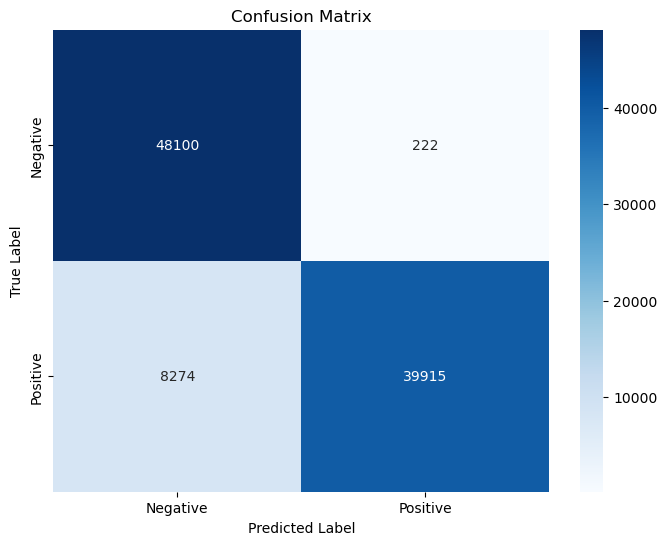

Accuracy of the SVC model on test set is 0.9119685838919915


In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = svc_grid_search.best_estimator_.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

# Labels for the classes
class_labels = ['Negative', 'Positive']

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)

# Adding titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()
print(f'Accuracy of the SVC model on test set is {test_accuracy}')

### Random Forest Classifier

Best Hyperparameters: {'max_depth': 12, 'min_samples_leaf': 26, 'min_samples_split': 133, 'n_estimators': 115}
Best Cross-Validation Score: 0.9952310777599583


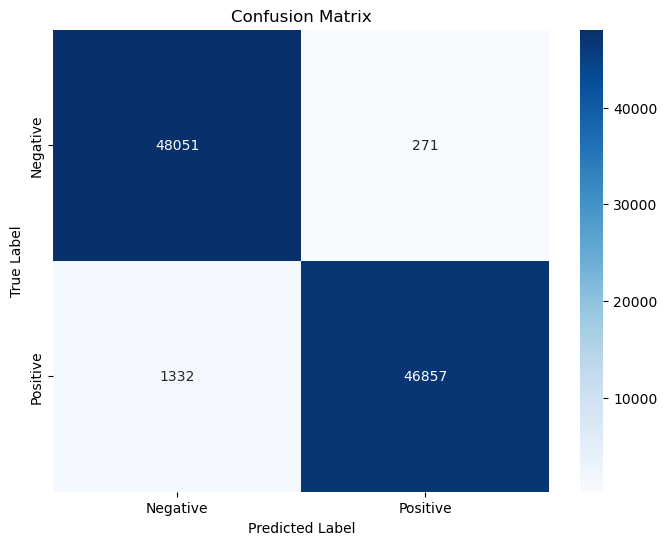

Accuracy of the Random Forest model on test set is 0.9833904943477946


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {"n_estimators":randint(110,120),
              "max_depth": randint(10,13),
              "min_samples_split": randint(110,150),
              "min_samples_leaf": randint(25,45)}
rf_clf = RandomForestClassifier(random_state=25,n_jobs=-1)
rf_random = RandomizedSearchCV(rf_clf, param_distributions=param_dist,
                                   n_iter=5,cv=5,scoring='accuracy',random_state=42,return_train_score=True)


# Fit the model
rf_random.fit(X_trained_pca, y_train)

# Get the best hyperparameters
print("Best Hyperparameters:", rf_random.best_params_)

# Get the best cross-validation score
print("Best Cross-Validation Score:", rf_random.best_score_)


# Predict the Result
y_pred = rf_random.best_estimator_.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_pred)


#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Labels for the classes
class_labels = ['Negative', 'Positive']

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)

# Adding titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()


print(f'Accuracy of the Random Forest model on test set is {test_accuracy}')

### KNN classifier

Best Hyperparameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best Cross-Validation Score: 0.9962542851395128


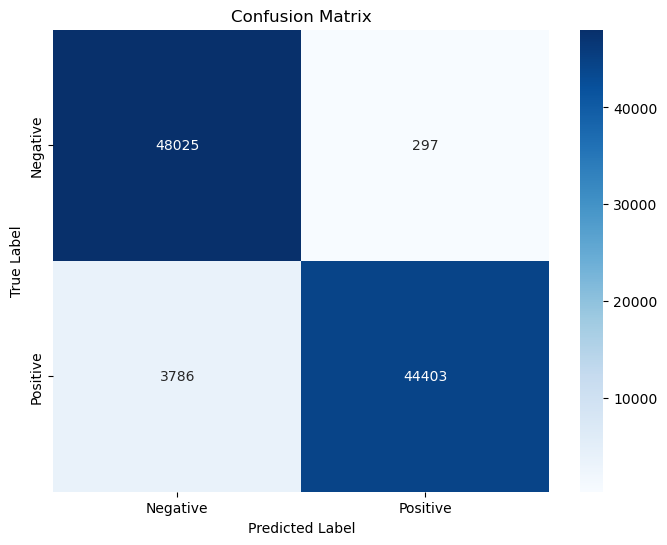

Accuracy of the KNN model on test set is 0.9576939416232346


In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the model
knn = KNeighborsClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform'],
    'algorithm': ['auto'],
    'metric': ['euclidean']
}

# Create GridSearchCV object
knn_grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=5)

# Fit the model to the data
knn_grid_search.fit(X_trained_pca, y_train)

# Get the best parameters
print("Best Hyperparameters:", knn_grid_search.best_params_)

# Get the best cross-validation score
print("Best Cross-Validation Score:", knn_grid_search.best_score_)


# Predict the Result
y_pred = knn_grid_search.best_estimator_.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_pred)


#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Labels for the classes
class_labels = ['Negative', 'Positive']

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)

# Adding titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()


print(f'Accuracy of the KNN model on test set is {test_accuracy}')